In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-14 16:41:03.032481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:41:03.079871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:41:03.079903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 16:41:03.081971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 16:41:03.091633: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-14 16:41:06.842279: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 16:41:06.900351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 16:41:06.900517: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path) # only laser power and velocity
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

feats = np.load(feats_path)
print("feats shape: ", feats.shape) # feats shape:  (100, 2, 2, 2, 2, 2, 2, 2, 2, 2)


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
feats shape:  (9587, 8)


In [3]:
# dimensions of MP are the index 1 and 2 of column in feat

dim_lh = feats[:, 1:3]

max_lh = dim_lh.max(axis=0)

# normalize dim_lh based on max value of each column
#dim_lh = dim_lh / max_lh

dim_lh


array([[ 27.,  22.],
       [ 26.,  25.],
       [ 33.,  22.],
       ...,
       [202.,  76.],
       [202.,  76.],
       [198.,  77.]])

In [4]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
# expand the dimension of x to 4D
manta = np.expand_dims(manta, axis=3)
xiris = np.expand_dims(xiris, axis=3)
x = np.concatenate((manta, xiris), axis=3)
y = dim_lh
print("x shape: ", x.shape)
print("y shape: ", y.shape)

x shape:  (9587, 320, 320, 2)
y shape:  (9587, 2)


In [5]:


# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x_train shape:  (7669, 320, 320, 2)
y_train shape:  (7669, 2)
x_test shape:  (1918, 320, 320, 2)
y_test shape:  (1918, 2)


In [6]:
del manta, xiris, y, dim_lh, x

In [7]:
def build_simpleCNN_model(resolution, n_channels, n_classes):
    """
        Build a simple CNN model with 2 convolutional layers, 2 max pooling layers, 1 fully connected layer and 1 output layer.
        The model is built using the Keras functional API.
        The model is compiled with the Adam optimizer and the categorical cross entropy loss function.
    """
    
    # Define the input shape
    input_shape = Input(shape=(resolution, resolution, n_channels))
    x = Conv2D(4, (3, 3), activation='relu')(input_shape) # 32
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(8, (3, 3), activation='relu')(x) # 64
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)

    # Add a fully connected layer with 128 units and a ReLU activation function
    #x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)
    # Add two output layers each with 1 unit and a linear activation function
    output1 = Dense(n_classes, activation="linear")(x)

    # Define the model with the specified input and outputs
    model = Model(inputs=input_shape, outputs=output1)
    return model

In [8]:
# build model
resolution = X_test.shape[1]
n_channels = X_test.shape[3]
n_classes = y_test.shape[1]

print("resolution: ", resolution)
print("n_channels: ", n_channels)
print("n_classes: ", n_classes)

# build model
model = build_simpleCNN_model(resolution, n_channels, n_classes)

# compile model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# print model summary
model.summary()

battch_size = 32
epochs = 20
validation_split = 0.2

# train model
history = model.fit(X_train, y_train,
                    batch_size=battch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=validation_split)


resolution:  320
n_channels:  2
n_classes:  2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 4)       76        
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 159, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 8)       296       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 78, 78, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatt

2024-01-14 16:41:27.007401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 16:41:27.007684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-14 16:41:27.007832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-01-14 16:41:40.046826: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-14 16:41:40.169429: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 16:41:40.869362: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-14 16:41:42.228117: I external/local_xla/xla/service/service.cc:168] XLA service 0x55ff4a658cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-14 16:41:42.228141: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-14 16:41:42.235876: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705250502.520604 1080820 device_compiler.h:186] 

192/192 [==============================] - 14s 47ms/step - loss: 1181.5342 - mse: 1181.5342 - mae: 17.6532 - val_loss: 123.9042 - val_mse: 123.9042 - val_mae: 6.1968
Epoch 2/20
192/192 [==============================] - 6s 30ms/step - loss: 76.9008 - mse: 76.9008 - mae: 5.1372 - val_loss: 65.6590 - val_mse: 65.6590 - val_mae: 4.9147
Epoch 3/20
192/192 [==============================] - 6s 29ms/step - loss: 43.9043 - mse: 43.9043 - mae: 3.9588 - val_loss: 64.8924 - val_mse: 64.8924 - val_mae: 5.7071
Epoch 4/20
192/192 [==============================] - 5s 27ms/step - loss: 39.3563 - mse: 39.3563 - mae: 3.8621 - val_loss: 38.7349 - val_mse: 38.7349 - val_mae: 3.6617
Epoch 5/20
192/192 [==============================] - 5s 27ms/step - loss: 31.6120 - mse: 31.6120 - mae: 3.3198 - val_loss: 31.1940 - val_mse: 31.1940 - val_mae: 2.8141
Epoch 6/20
192/192 [==============================] - 5s 27ms/step - loss: 29.9363 - mse: 29.9363 - mae: 3.3187 - val_loss: 29.5013 - val_mse: 29.5013 - val_m

In [9]:
# save model
#model.save("simpleCNN_model.h5")

In [10]:
# evaluate model
score = model.evaluate(X_test, y_test)
print(score)

60/60 [==============================] - 1s 16ms/step - loss: 13.7368 - mse: 13.7368 - mae: 2.6081
[13.736759185791016, 13.736759185791016, 2.608102560043335]


60/60 [==============================] - 1s 14ms/step
r2 score:  0.9798502297519887


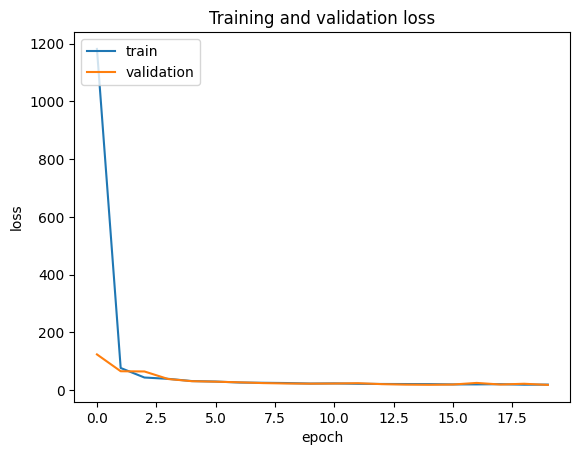

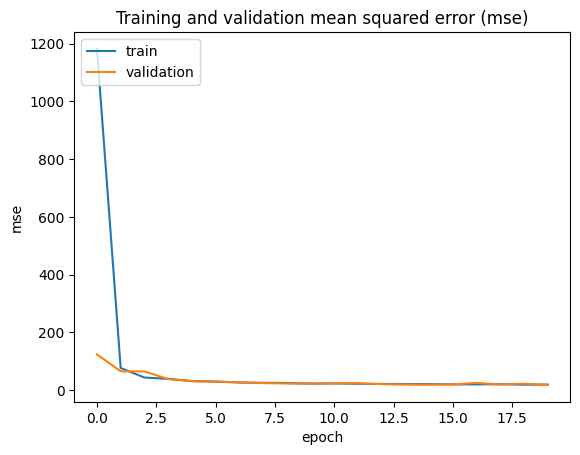

" # plot mse and mae in the same plot\nplt.plot(history.history['mse'])\nplt.plot(history.history['mae'])\nplt.title('Simple CNN model metrics')\nplt.ylabel('metrics')\n\nplt.xlabel('epoch')\nplt.legend(['mse', 'mae'], loc='upper left')\nplt.show() "

In [11]:
# eval regression model
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("r2 score: ", r2)



# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# train and validation mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Training and validation mean squared error (mse)')
plt.ylabel('mse')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

""" # plot mse and mae in the same plot
plt.plot(history.history['mse'])
plt.plot(history.history['mae'])
plt.title('Simple CNN model metrics')
plt.ylabel('metrics')

plt.xlabel('epoch')
plt.legend(['mse', 'mae'], loc='upper left')
plt.show() """




In [12]:
# make a black image with the same shape as X_test[0]
black_image = np.zeros(X_test[0].shape[0])
print(black_image.shape)

# replace the second channel with the black image 
X_test_new = np.copy(X_test)
X_test_new[:, :, :, 1] = black_image

""" x = X_test_new[10]
# plot first and second channel of x
plt.imshow(x[:, :, 0])
plt.show()
plt.imshow(x[:, :, 1])
plt.show()
 """

(320,)


' x = X_test_new[10]\n# plot first and second channel of x\nplt.imshow(x[:, :, 0])\nplt.show()\nplt.imshow(x[:, :, 1])\nplt.show()\n '

In [13]:
# evL«aluate model with the new X_test_new
score_new = model.evaluate(X_test_new, y_test)
print(score)


60/60 [==============================] - 1s 17ms/step - loss: 20343.6309 - mse: 20343.6309 - mae: 129.1907
[13.736759185791016, 13.736759185791016, 2.608102560043335]


In [14]:
y_pred

array([[174.42297 ,  79.1144  ],
       [127.61521 ,  61.151913],
       [ 62.393803,  44.673138],
       ...,
       [121.89986 ,  58.0025  ],
       [135.65015 ,  71.517784],
       [121.11855 ,  71.48493 ]], dtype=float32)

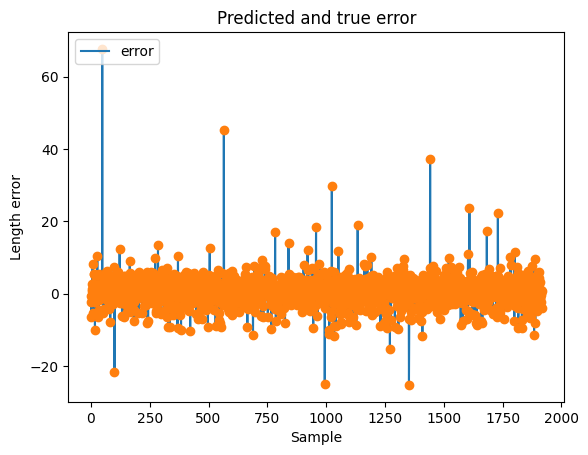

In [15]:
# plot predicted and true error
plt.plot(y_pred[:, 0] - y_test[:, 0])
plt.title('Predicted and true error')
plt.ylabel('Length error')
plt.xlabel('Sample')
plt.legend(['error'], loc='upper left')
# dot not line
plt.plot(y_pred[:, 0] - y_test[:, 0], 'o')
plt.show()


score:  [13.736759185791016, 13.736759185791016, 2.608102560043335]
score_new:  [20343.630859375, 20343.630859375, 129.19073486328125]
60/60 [==============================] - 1s 13ms/step
(1918, 2)


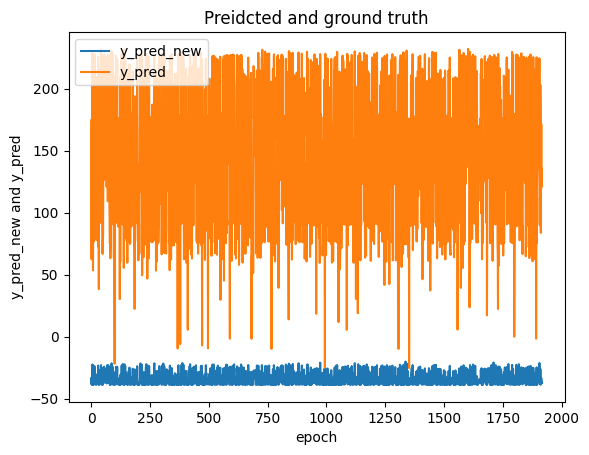

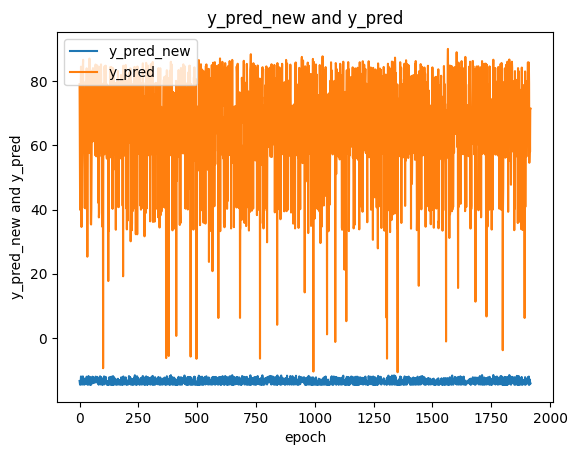

In [16]:
# compare score and score_new
print("score: ", score)
print("score_new: ", score_new)

# predict y_pred_new
y_pred_new = model.predict(X_test_new)
print(y_pred_new.shape)

# plot y_pred_new and y_pred
plt.plot(y_pred_new[:, 0])
plt.plot(y_pred[:, 0])
plt.title('Preidcted and ground truth')
plt.ylabel('y_pred_new and y_pred')

plt.xlabel('epoch')
plt.legend(['y_pred_new', 'y_pred'], loc='upper left')
plt.show()

# plot y_pred_new and y_pred
plt.plot(y_pred_new[:, 1])
plt.plot(y_pred[:, 1])
plt.title('y_pred_new and y_pred')
plt.ylabel('y_pred_new and y_pred')

plt.xlabel('epoch')
plt.legend(['y_pred_new', 'y_pred'], loc='upper left')
plt.show()
